# QuDPy example1 notebook

### importing the required files

In [ ]:
# use this cell for installing packages on google colab environment.
!pip install qudpy

In [2]:
from qutip import *  # for quantum dynamics
import numpy as np  # for numerical manipulations
from qudpy.Classes import *  # for nonlinear spectroscpy
import qudpy.plot_functions as pf  # for plotting nonlinear spectra
import ufss  # for double-sided diagram generation

In [3]:
# Generating the 3rd order double-sided diagrams for rephasing and non-rephasing response
# in impulsive regime.

DG = ufss.DiagramGenerator
R3rd = DG()
# setting condition for rephasing diagrams R1,2,3
R3rd.set_phase_discrimination([(0, 1), (1, 0), (1, 0)])
# Set the pulse interval
t_pulse = np.array([-1, 1])
R3rd.efield_times = [t_pulse]*4
# Creating diagrams for pulse arrival times 0, 100, 200 and detection time 300.
[R3, R1, R2] = R3rd.get_diagrams([0, 100, 200, 300])
rephasing = [R1, R2, R3]
print('the rephasing diagrams are R1, R2 and R3 ', rephasing)

# setting conditions for and generating non-rephasing diagrams R4, R5 and R6
R3rd.set_phase_discrimination([(1, 0), (0, 1), (1, 0)])
[R6, R4, R5] = R3rd.get_diagrams([0, 100, 200, 200])
nonrephasing = [R4, R5, R6]
print('the non-rephasing diagrams are R4, R5 and R6', nonrephasing)

the rephasing diagrams are R1, R2 and R3  [(('Bu', 0), ('Ku', 1), ('Bd', 2)), (('Bu', 0), ('Bd', 1), ('Ku', 2)), (('Bu', 0), ('Ku', 1), ('Ku', 2))]
the non-rephasing diagrams are R4, R5 and R6 [(('Ku', 0), ('Bu', 1), ('Bd', 2)), (('Ku', 0), ('Kd', 1), ('Ku', 2)), (('Ku', 0), ('Bu', 1), ('Ku', 2))]


In [4]:
# constructing the Hamiltonian
hbar = 0.658211951  # in eV fs
E1 = 2  # eV
E2 = 2.1  # eV
w1 = E1/hbar  # frequency
w2 = E2/hbar  # frequency
j = -0.3/hbar  # coupling
mu1 = 1.0  # dipole strength for subsystem A
mu2 = 1.0  # dipole strength for subsystem B
a = tensor(destroy(2), qeye(2))  # lowering operator for subsystem A
b = tensor(qeye(2), destroy(2))  # lowering operator of subsystem B
A = mu1*a + mu2*b  # total lowering operator for full system
mu = mu1*(a.dag()+a) + mu2*(b.dag()+b)  # total dipole operator
H = hbar*(w1*a.dag()*a + w2*b.dag()*b)  # basic Hamiltonian
H += hbar*j*(a.dag()*b+b.dag()*a)  # coupling between subsystems

In [5]:
# creating collapse operators using system-bath couplings
kappa = 0.1  # internal relaxation
kB = 8.617333262*1e-5  # Boltzmann constant eV/K
T = 300  # temperature in K
kT = T*kB
beta = 1/kT
n1 = 1/(np.exp(E1*beta)-1)  # <n1>, thermal populations of the uncoupled states
n2 = 1/(np.exp(E2*beta)-1)  # <n2>, thermal populations of the uncoupled states
c1 = np.sqrt(kappa*(n1+1))*a  # relaxation operators
c2 = np.sqrt(kappa*(n2+1))*b  # relaxation operators
c3 = np.sqrt(kappa*n1)*a.dag()  # excitation operators
c4 = np.sqrt(kappa*n2)*b.dag()  # excitation operators
c_ops = [c1, c2, c3, c4]  # collapse operator list

In [6]:

# setting up system
rho = tensor(fock_dm(2, 0), fock_dm(2, 0))  # ground state of Hamiltonian
sys = System(H=H, rho=rho, a=A, u=mu, c_ops=c_ops, diagonalize=True)

diagonalizing Hamiltonian and transforming everything into eigen-basis except rho
system initialized


total diagrams 1 , total interactions  3
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)
('Bu', 0)
('Ku', 1)
('Bd', 2)


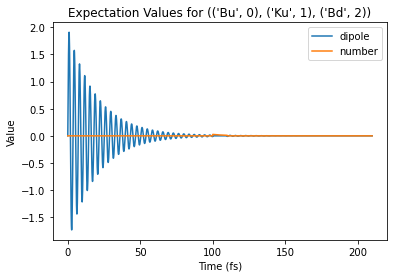

In [7]:
# generating single trial for R1
sys.diagram_donkey([0, 100, 110, 210], [R1])

First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors
second scan done
First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors
second scan done
First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors
second scan done
First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors
second scan done
First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors
second scan done
First scan done, starting second scan. Remaining time = First Scan Time x number of steps in second scan/number of processors
second scan done
centering data around zero


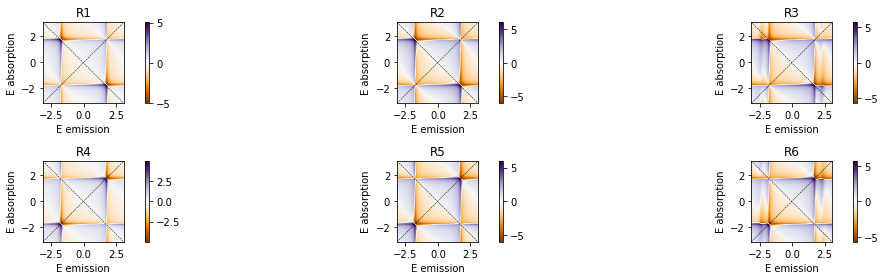

In [8]:
# generating 2Dcoherence response for rephasing
time_delays = [100, 10, 100]
scan_id = [0, 2]
response_list = []
total_diagrams = rephasing+nonrephasing
for k in range(6):
    states, t1, t2, dipole = sys.coherence2d(time_delays, total_diagrams[k], scan_id, r=1, parallel=True)
    response_list.append(1j*dipole)
spectra_list, extent, f1, f2 = sys.spectra(np.imag(response_list), resolution=1)
qsave(spectra_list, 'example1_res1_spectra_list')
qsave(response_list, 'exampel1_res1_response_list')
pf.multiplot(np.imag(spectra_list), extent, ['E emission', 'E absorption'], ['R1', 'R2', 'R3', 'R4', 'R5', 'R6'], 'log',
             color_map='PuOr')


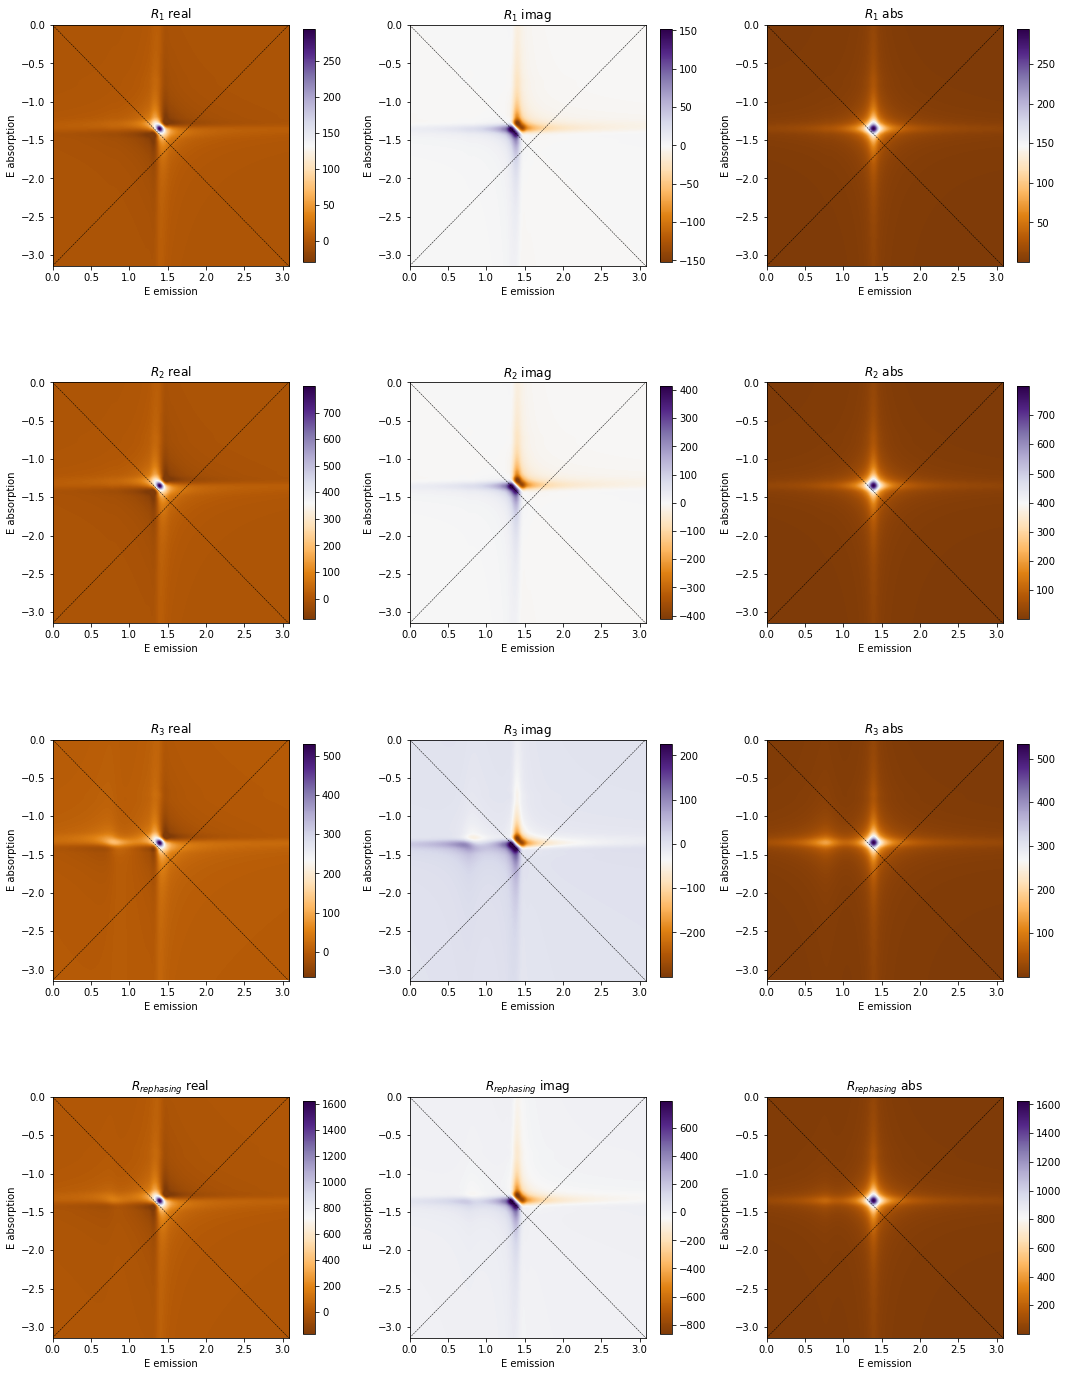

In [9]:
rephasing_spectra = spectra_list[:3]
rephasing_spectra.append(np.sum(spectra_list[:3], 0))
pf.silva_plot(rephasing_spectra, scan_range=extent, labels=['E emission', 'E absorption'],
              title_list=['$R_1$', '$R_2$', '$R_3$', '$R_{rephasing}$'], scale='linear', color_map='PuOr',
              interpolation='spline36', center_scale=False, plot_sum=False, plot_quadrant='4', invert_y=False,
              diagonals=[True, True])

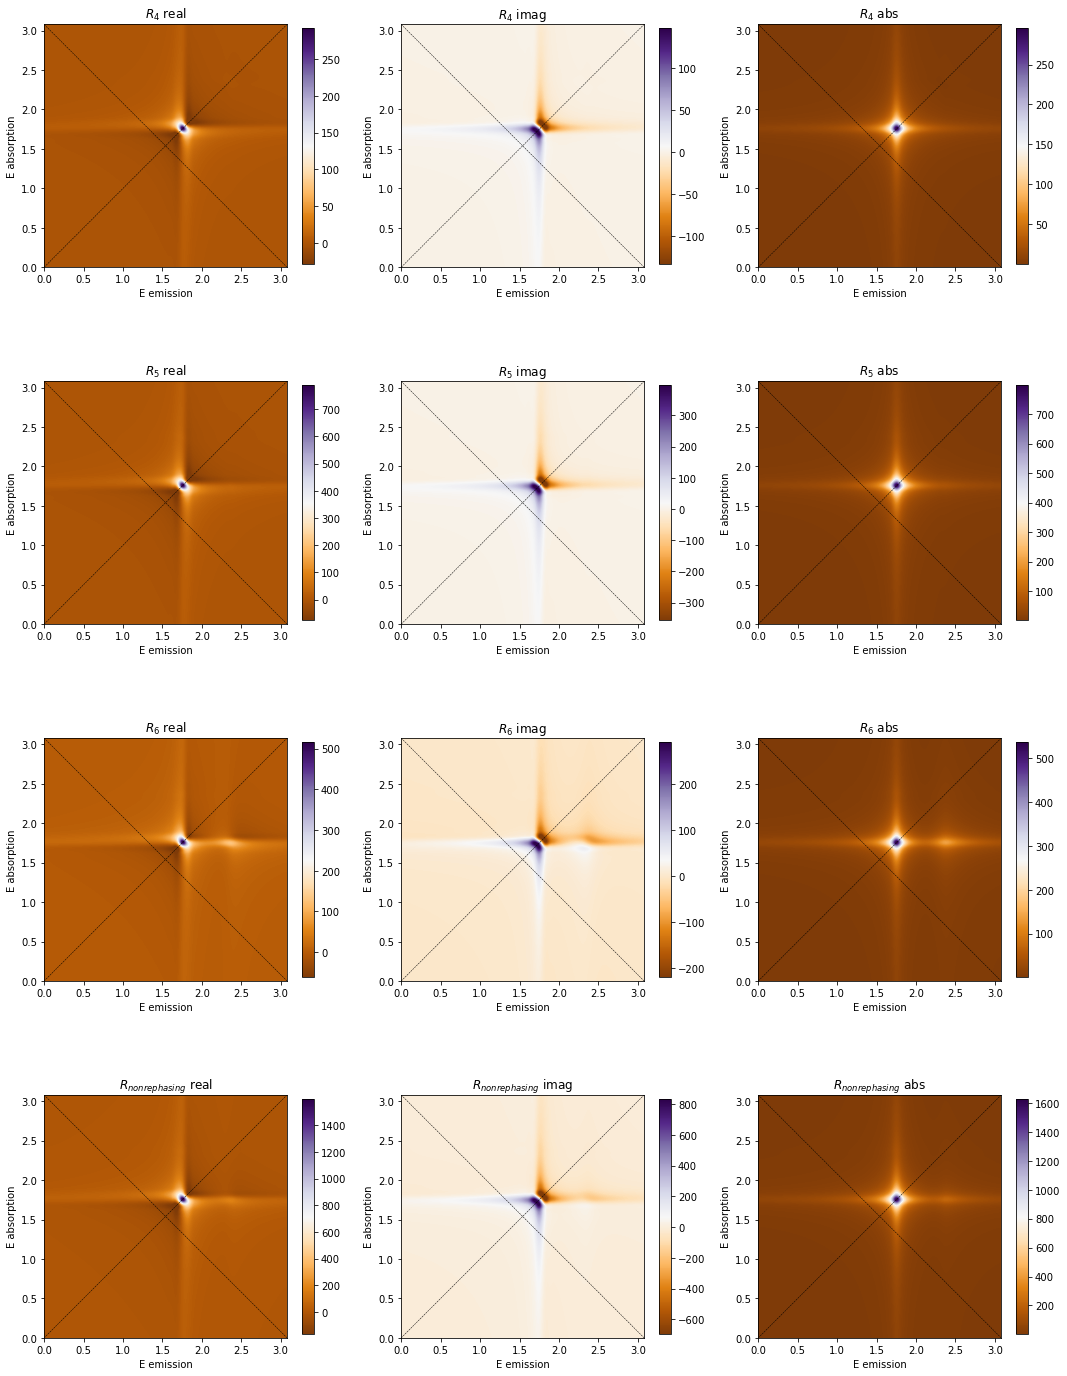

In [10]:
nonrephasing_spectra = spectra_list[3:]
nonrephasing_spectra.append(np.sum(spectra_list[3:], 0))
pf.silva_plot(nonrephasing_spectra, scan_range=extent, labels=['E emission', 'E absorption'],
              title_list=['$R_4$', '$R_5$', '$R_6$', '$R_{nonrephasing}$'], scale='linear', color_map='PuOr',
              interpolation='spline36', center_scale=False, plot_sum=False, plot_quadrant='1', invert_y=False,
              diagonals=[True, True])

centering data around zero
using log scale


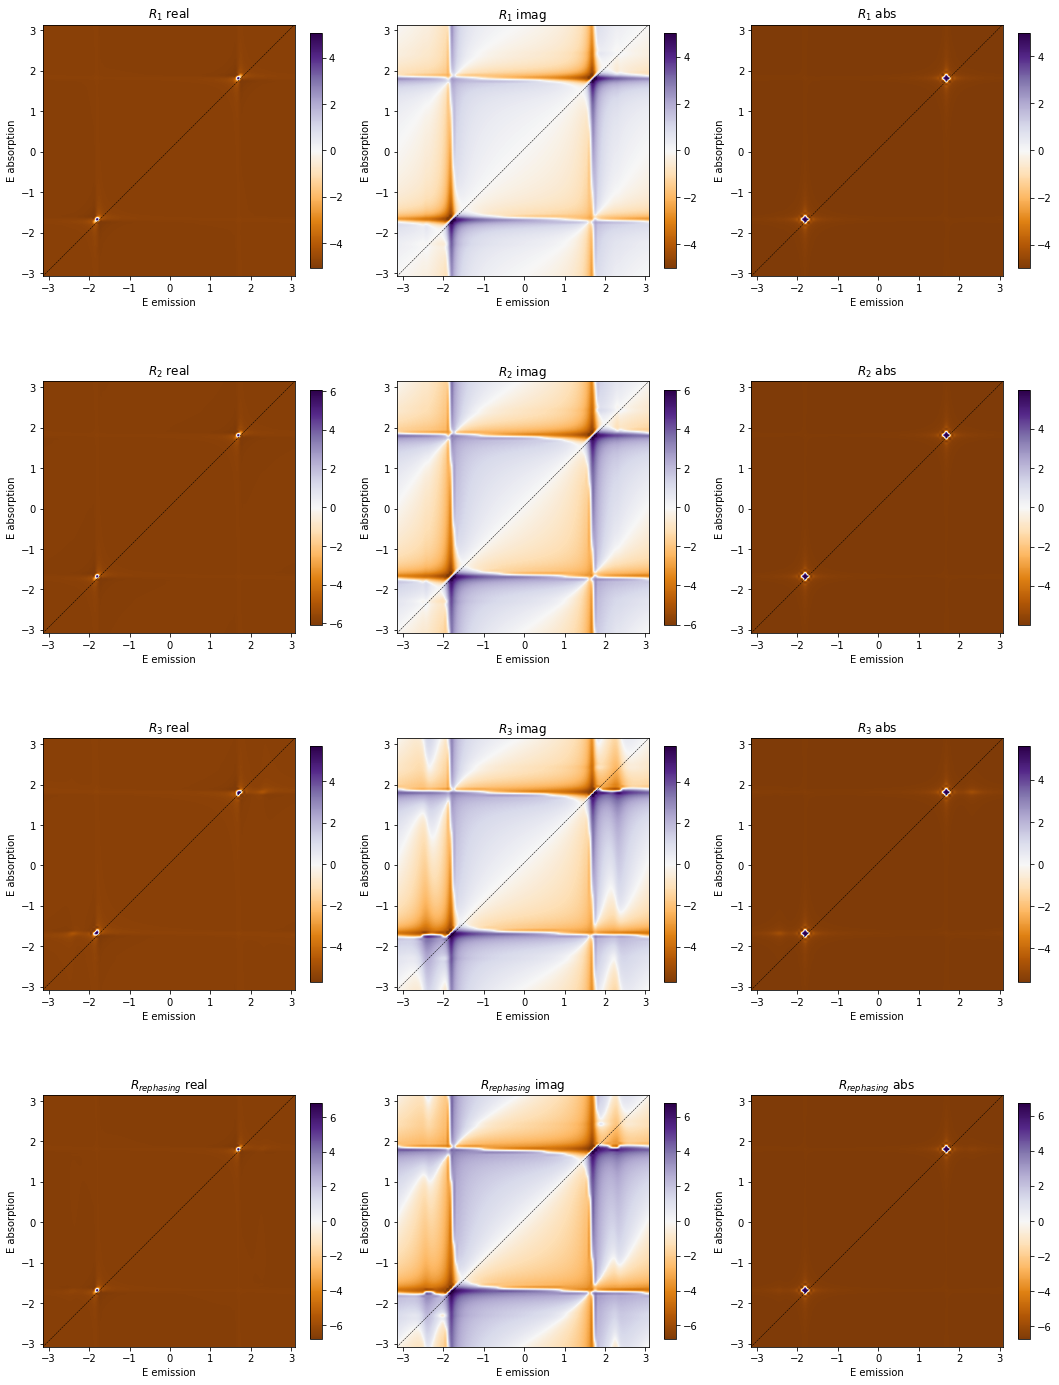

In [11]:
pf.silva_plot(rephasing_spectra, scan_range=extent, labels=['E emission', 'E absorption'],
              title_list=['$R_1$', '$R_2$', '$R_3$', '$R_{rephasing}$'], scale='log', color_map='PuOr',
              interpolation='spline36', center_scale=True, plot_sum=False, plot_quadrant='All', invert_y=True,
              diagonals=[False, True])


centering data around zero
using log scale


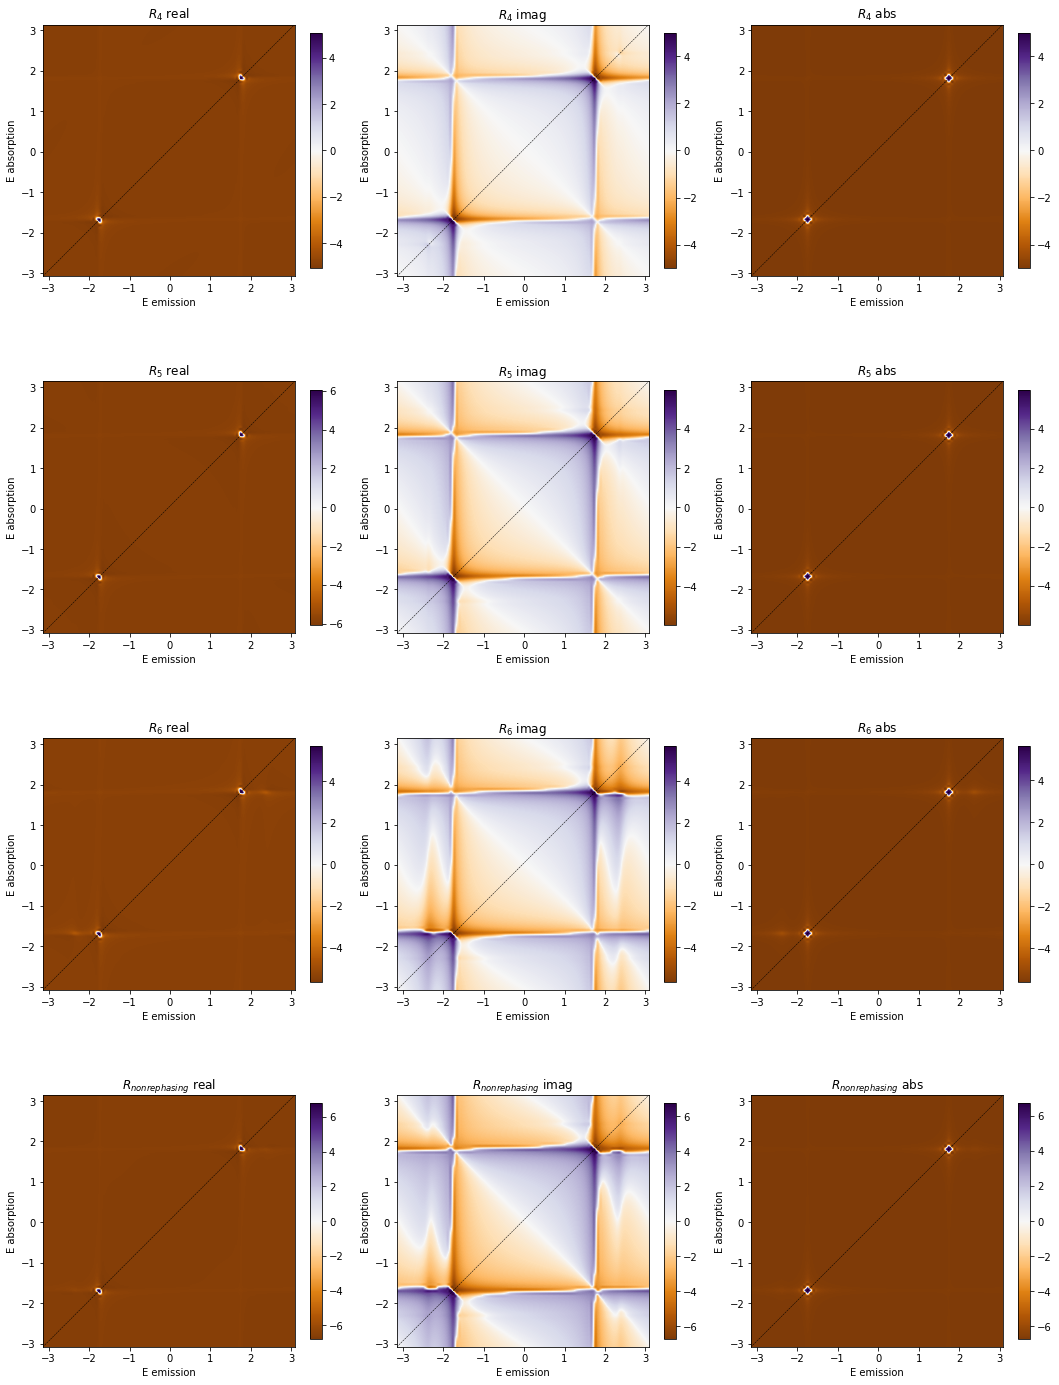

In [12]:
pf.silva_plot(nonrephasing_spectra, scan_range=extent, labels=['E emission', 'E absorption'],
              title_list=['$R_4$', '$R_5$', '$R_6$', '$R_{nonrephasing}$'], scale='log', color_map='PuOr',
              interpolation='spline36', center_scale=True, plot_sum=False, plot_quadrant='All', invert_y=False,
              diagonals=[False, True])